Ensures that the tickers are well visible, have finviz data that are readable and filters them by unaccetable levels of P/E, P/S and Debt/Eqt ratios

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from finvizfinance.quote import finvizfinance

# Set aesthetics
sns.set(style='whitegrid', font_scale=1.1)

In [2]:
pred_col = 'final_return_1m_raw'
pred_signal_threshold = 0.06

In [3]:
# --- CONFIG ---
# Replace with your prediction file path
bounds = {
    'Pred': (-0.02, 0.02),       # Adjust based on your prediction scale
    'P/E': (5, 50),
    'P/S': (1, 5),
    'Debt/Eq': (0, 2),
}

higher_is_better = {
    'P/E': False,
    'P/S': False,
    'Debt/Eq': False,
    'Pred': True
}

In [4]:
# --- LOAD PREDICTIONS ---
pred_path = f"data/inference/{pred_col}_inference_output.xlsx"

# --- LOAD PREDICTIONS ---
df_pred = pd.read_excel(pred_path)  # use pd.read_csv(path) if it's a CSV

# Rename columns for consistency
df_pred.columns = [col.strip() for col in df_pred.columns]
pred_col = [col for col in df_pred.columns if pred_col in col and "score" in col][0]

# Keep only relevant columns
df_pred = df_pred[['Ticker', 'Filing Date', pred_col]]
df_pred = df_pred.rename(columns={pred_col: 'Pred'})

# Convert date
df_pred['Filing Date'] = pd.to_datetime(df_pred['Filing Date'], dayfirst=True, errors='coerce')

# Check
print("✅ Loaded predictions:", df_pred.shape)
display(df_pred.head())


✅ Loaded predictions: (32, 3)


,Ticker,Filing Date,Pred
0,BCDA,2025-07-03 09:00:00,0.026833
1,NYC,2025-07-03 09:00:00,-0.021750
2,WELL,2025-07-02 17:00:00,-0.026763
3,FGEN,2025-07-02 17:00:00,0.088701
4,TCBI,2025-07-02 17:00:00,-0.026400


In [5]:
from finvizfinance.quote import finvizfinance

def get_finviz_fundamentals(ticker):
    """
    Fetches basic fundamental ratios from Finviz for a given ticker.
    Returns a dictionary with P/E, P/S, and Debt/Eq if available.
    """
    stock = finvizfinance(ticker)
    info = stock.ticker_fundament()
    
    def parse_ratio(value):
        try:
            return float(value)
        except:
            return np.nan

    return {
        "P/E": parse_ratio(info.get("P/E")),
        "P/S": parse_ratio(info.get("P/S")),
        "Debt/Eq": parse_ratio(info.get("Debt/Eq"))
    }

In [6]:
from tqdm import tqdm

# --- PREPARE TICKERS ---
tickers = df_pred['Ticker'].unique()

# --- FETCH FUNDAMENTALS ---
fundamental_data = []

for ticker in tqdm(tickers):
    try:
        finviz_data = get_finviz_fundamentals(ticker)
        time.sleep(1)
        finviz_data['Ticker'] = ticker
        fundamental_data.append(finviz_data)
    except Exception as e:
        print(f"⚠️ Error for {ticker}: {e}")

df_fund = pd.DataFrame(fundamental_data)
print(f"✅ Retrieved fundamentals for {len(df_fund)} tickers.")

 32%|███▏      | 9/28 [00:10<00:17,  1.06it/s]

⚠️ Error for QNBC: HTTP error for URL https://finviz.com/quote.ashx?t=QNBC: 404 Client Error: Not Found for url: https://finviz.com/quote.ashx?t=QNBC


100%|██████████| 28/28 [00:34<00:00,  1.22s/it]

⚠️ Error for CSBB: HTTP error for URL https://finviz.com/quote.ashx?t=CSBB: 404 Client Error: Not Found for url: https://finviz.com/quote.ashx?t=CSBB
✅ Retrieved fundamentals for 26 tickers.


In [7]:
# --- MERGE ---
df = df_pred[['Ticker', 'Pred']].merge(df_fund, on='Ticker', how='left')
print(f"✅ Merged DataFrame: {df.shape}")

✅ Merged DataFrame: (32, 5)


In [8]:
df = df.dropna(subset=bounds.keys())

# --- NORMALIZE FUNCTION ---
def normalize(val, low, high, higher_better=True):
    if pd.isna(val):
        return np.nan
    norm = (val - low) / (high - low)
    norm = np.clip(norm, 0, 1)
    return norm if higher_better else 1 - norm

# --- NORMALIZE EACH COLUMN ---
df_norm = df.copy().drop_duplicates(subset="Ticker", keep="first")
for col in bounds:
    norm_col = col + ' (Norm)'
    low, high = bounds[col]
    df_norm[norm_col] = df[col].apply(normalize, args=(low, high, higher_is_better[col]))

C:\Users\user\AppData\Local\Temp\ipykernel_27164\110146390.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\user\.conda\envs\insideralgo\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


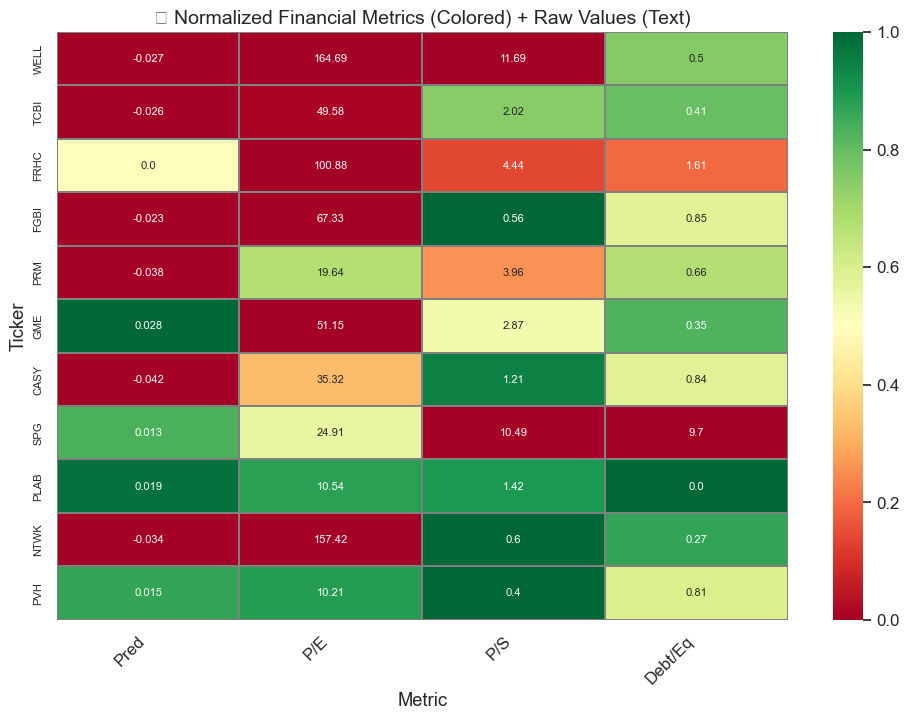

In [9]:
# --- HEATMAP MATRIX (Normalized values) ---
norm_cols = [col + ' (Norm)' for col in bounds]
raw_cols = list(bounds.keys())

# Ensure all necessary columns exist
assert all(c in df_norm.columns for c in norm_cols), "Missing normalized columns"
assert all(c in df_norm.columns for c in raw_cols), "Missing raw columns"

# Construct matrices
heatmap_values = df_norm.set_index('Ticker')[norm_cols].copy()
heatmap_values.columns = raw_cols
annotations = df_norm.set_index('Ticker')[raw_cols].round(3).astype(str)

# --- PLOT HEATMAP ---
plt.figure(figsize=(len(raw_cols) * 2.5, len(heatmap_values) * 0.4 + 3))
sns.heatmap(
    heatmap_values,
    cmap="RdYlGn",
    annot=annotations,
    fmt='',
    linewidths=0.3,
    linecolor='gray',
    cbar=True,
    annot_kws={"size": 8}
)

plt.title("📊 Normalized Financial Metrics (Colored) + Raw Values (Text)", fontsize=14)
plt.ylabel("Ticker")
plt.xlabel("Metric")
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [10]:
def classify_risk_pe(pe):
    if pd.isna(pe): return np.nan
    if 0 < pe <= 20: return 1
    if 20 < pe <= 40: return 0.5
    return 0

def classify_risk_ps(ps):
    if pd.isna(ps): return np.nan
    if ps <= 4: return 1
    if ps <= 10: return 0.5
    return 0

def classify_risk_de(de):
    if pd.isna(de): return np.nan
    if de <= 1: return 1
    if de <= 2: return 0.5
    return 0

In [14]:
# --- COMPOSITE SCORE CONFIG ---
pred_weight = 0.6
risk_weight = 0.4

# --- RISK SCORES ---
df_norm['P/E Risk'] = df_norm['P/E'].apply(classify_risk_pe)
df_norm['P/S Risk'] = df_norm['P/S'].apply(classify_risk_ps)
df_norm['Debt/Eq Risk'] = df_norm['Debt/Eq'].apply(classify_risk_de)
df_norm['Risk Score'] = df_norm[['P/E Risk', 'P/S Risk', 'Debt/Eq Risk']].mean(axis=1)

# --- PREDICTION SCORE + BOOLEAN SIGNAL ---
df_norm['Pred Score'] = (df_norm['Pred'] >= pred_signal_threshold).astype(int)

# --- FILTER VALID ENTRIES ---
df_valid = (
    df_norm
    .dropna(subset=['Pred Score', 'Risk Score'])
    .drop_duplicates(subset='Ticker', keep='first')
    .copy()
)

# --- COMPUTE COMPOSITE SCORE ---
df_valid['Composite Score'] = (
    df_valid['Pred Score'] * pred_weight +
    df_valid['Risk Score'] * risk_weight
)

# --- RANKING ---
df_valid['Rank'] = df_valid['Composite Score'].rank(method='max', ascending=False).astype(int)
df_valid = df_valid.sort_values(by='Composite Score', ascending=False)

# --- FINAL OUTPUT TABLE ---
final_table = df_valid[['Ticker', 'Composite Score', 'Risk Score', 'Pred Score']].round(2)
final_table = final_table.reset_index(drop=True)
final_table.index += 1

print("🏆 Ranked Stocks by Prediction & Risk-Aware Composite Score:")
print(final_table)

🏆 Ranked Stocks by Prediction & Risk-Aware Composite Score:
   Ticker  Composite Score  Risk Score  Pred Score
1     PRM             0.40        1.00           0
2    PLAB             0.40        1.00           0
3     PVH             0.40        1.00           0
4    CASY             0.33        0.83           0
5    TCBI             0.27        0.67           0
6    FGBI             0.27        0.67           0
7     GME             0.27        0.67           0
8    NTWK             0.27        0.67           0
9    WELL             0.13        0.33           0
10   FRHC             0.13        0.33           0
11    SPG             0.07        0.17           0


In [15]:
# --- FILTER by Composite Score === 1 ---
perfect_scores = df_valid[df_valid['Composite Score'] == 1].copy()

# Optional: sort by any additional field (e.g., Pred Score)
perfect_scores = perfect_scores.sort_values(by='Pred Score', ascending=False)

# Display final filtered table
print("🌟 Stocks with Perfect Composite Score (1.0):")
print(perfect_scores[['Ticker', 'Composite Score', 'Pred Score', 'Risk Score']].reset_index(drop=True))

🌟 Stocks with Perfect Composite Score (1.0):
Empty DataFrame
Columns: [Ticker, Composite Score, Pred Score, Risk Score]
Index: []
